In [785]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [786]:
#!pip install tqdm

In [787]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv')
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv')

In [788]:
df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [789]:
df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [790]:
#df0 = df0.reset_index(drop=True)

In [791]:
df0.head()

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0,12.4750,13.3580,12.509969,12.304971,12.4570,0,13.3560,493632.0,12.323680,...,12.59940,12.531571,0,1,do_nothing,go_short,do_nothing,2.765190,255233.982115,238398.017885
1,1,301.0800,306.6000,297.368301,293.048934,300.3800,0,305.8700,97836.0,291.372800,...,300.17800,299.475714,0,1,do_nothing,go_short,do_nothing,0.301170,49304.056875,48531.943125
2,2,626.6400,631.9500,618.904756,612.673035,625.6200,0,627.1800,26240.0,615.152000,...,623.06600,620.297143,0,0,go_long,go_short,do_nothing,-1.788648,13125.650572,13114.349428
3,3,0.3788,0.3846,0.371708,0.362725,0.3774,1,0.3812,24478.0,0.361024,...,0.37754,0.376686,0,1,do_nothing,go_short,do_nothing,0.303548,12277.649474,12200.350526
4,4,1.0155,1.0440,0.990258,0.971368,1.0134,0,1.0309,196121.0,0.977404,...,0.99874,0.992914,0,1,do_nothing,go_short,do_nothing,0.529565,98798.445514,97322.554486


In [792]:
df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [793]:
df0['action'].value_counts()

action
go_long       512
do_nothing    425
Name: count, dtype: int64

In [794]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [795]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [796]:
train_data = df0 #prep_data(df0)

In [797]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,12.475,13.358,12.509969,12.304971,12.457,0,13.356,493632.0,12.32368,0,...,12.5994,12.531571,0,1,do_nothing,go_short,do_nothing,2.76519,255233.982115,238398.017885
1,301.080,306.600,297.368301,293.048934,300.380,0,305.870,97836.0,291.37280,0,...,300.1780,299.475714,0,1,do_nothing,go_short,do_nothing,0.30117,49304.056875,48531.943125


In [798]:
new_cols = ['ask','bid','sma-compare','is_short']

In [799]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["nlpreds"].map(action_mapping)

In [800]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [801]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [802]:
# Hyperparameters [0.25, 0.95, 1.0, 0.99, 0.99, 10000], [0.9, 0.95, 1.0, 0.99, 0.99, 8000], [0.7, 0.75, 1.0, 0.97, 0.999, 28000]
# [0.05, 0.95, 1.0, 0.999, 0.995, 12000], [1, 0.95, 0.1, 0.96, 0.96, 12000], [0.25, 0.99, 0.01, 0.997, 0.99, 8000]
# [1, 0.75, 0.05, 0.999, 0.999, 10000], [0.01, 0.85, 0.01, 0.95, 0.95, 12000], [0.01, 0.99, 1.0, 0.95, 0.99, 16000], [0.05, 0.99, 0.5, 0.99, 0.997, 6000]
# [0.25, 0.95, 0.01, 0.997, 0.999, 14000], [0.01, 0.95, 1.0, 0.997, 0.995, 26000], [0.9, 0.99, 0.5, 0.995, 0.95, 12000], [1, 0.75, 0.005, 0.95, 0.95, 22000]
# [0.005, 0.75, 0.1, 0.95, 0.999, 12000], [0.25, 0.75, 0.01, 0.995, 0.999, 20000]
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''
alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = 0.25, 0.75, 0.01, 0.995, 0.999, 20000 # 0.9, 0.99, 0.5, 0.995, 0.95, 12000



In [803]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['ask'], row['bid'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('bids_state_to_index.npy', state_to_index)


In [804]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   0%|          | 43/20000 [00:00<01:34, 210.34it/s]

Episode 0/20000 - Total Reward: -177.20485005000003, Epsilon: 0.995


evaluating results per episode ...:   2%|▏         | 447/20000 [00:01<00:54, 356.36it/s]

Episode 400/20000 - Total Reward: -31.95680615, Epsilon: 0.995


evaluating results per episode ...:   4%|▍         | 884/20000 [00:02<00:59, 321.92it/s]

Episode 800/20000 - Total Reward: -159.25989258, Epsilon: 0.995


evaluating results per episode ...:   6%|▋         | 1267/20000 [00:04<01:06, 281.34it/s]

Episode 1200/20000 - Total Reward: -107.35431969000011, Epsilon: 0.995


evaluating results per episode ...:   8%|▊         | 1640/20000 [00:05<00:59, 308.28it/s]

Episode 1600/20000 - Total Reward: -162.05267374000002, Epsilon: 0.995


evaluating results per episode ...:  10%|█         | 2061/20000 [00:06<00:55, 323.27it/s]

Episode 2000/20000 - Total Reward: -128.37059123999998, Epsilon: 0.995


evaluating results per episode ...:  12%|█▏        | 2470/20000 [00:07<00:52, 334.49it/s]

Episode 2400/20000 - Total Reward: -124.60556944000005, Epsilon: 0.995


evaluating results per episode ...:  14%|█▍        | 2869/20000 [00:09<00:53, 322.23it/s]

Episode 2800/20000 - Total Reward: -156.97740388000003, Epsilon: 0.995


evaluating results per episode ...:  16%|█▋        | 3259/20000 [00:10<00:52, 321.92it/s]

Episode 3200/20000 - Total Reward: -18.711468720000006, Epsilon: 0.995


evaluating results per episode ...:  18%|█▊        | 3646/20000 [00:11<00:47, 341.20it/s]

Episode 3600/20000 - Total Reward: -35.770985630000006, Epsilon: 0.995


evaluating results per episode ...:  20%|██        | 4051/20000 [00:12<00:48, 331.19it/s]

Episode 4000/20000 - Total Reward: -104.55231822000009, Epsilon: 0.995


evaluating results per episode ...:  22%|██▏       | 4456/20000 [00:13<00:45, 338.58it/s]

Episode 4400/20000 - Total Reward: -161.12026534000003, Epsilon: 0.995


evaluating results per episode ...:  24%|██▍       | 4848/20000 [00:15<00:49, 309.05it/s]

Episode 4800/20000 - Total Reward: -59.52646926999997, Epsilon: 0.995


evaluating results per episode ...:  26%|██▋       | 5266/20000 [00:16<00:43, 335.68it/s]

Episode 5200/20000 - Total Reward: -103.41401462000006, Epsilon: 0.995


evaluating results per episode ...:  28%|██▊       | 5654/20000 [00:17<00:41, 345.88it/s]

Episode 5600/20000 - Total Reward: -18.120386340000003, Epsilon: 0.995


evaluating results per episode ...:  30%|███       | 6056/20000 [00:18<00:39, 356.67it/s]

Episode 6000/20000 - Total Reward: -3.0738527500000012, Epsilon: 0.995


evaluating results per episode ...:  32%|███▏      | 6467/20000 [00:19<00:40, 332.56it/s]

Episode 6400/20000 - Total Reward: -160.41081276000003, Epsilon: 0.995


evaluating results per episode ...:  34%|███▍      | 6853/20000 [00:21<00:37, 352.52it/s]

Episode 6800/20000 - Total Reward: 0.08967700000000006, Epsilon: 0.995


evaluating results per episode ...:  36%|███▋      | 7259/20000 [00:22<00:37, 343.25it/s]

Episode 7200/20000 - Total Reward: -0.7480326999999997, Epsilon: 0.995


evaluating results per episode ...:  38%|███▊      | 7660/20000 [00:23<00:40, 302.99it/s]

Episode 7600/20000 - Total Reward: -158.29950757999998, Epsilon: 0.995


evaluating results per episode ...:  40%|████      | 8041/20000 [00:24<00:45, 262.50it/s]

Episode 8000/20000 - Total Reward: -107.49588859000009, Epsilon: 0.995


evaluating results per episode ...:  42%|████▏     | 8468/20000 [00:26<00:33, 339.92it/s]

Episode 8400/20000 - Total Reward: -63.78169048999997, Epsilon: 0.995


evaluating results per episode ...:  44%|████▍     | 8868/20000 [00:27<00:31, 351.52it/s]

Episode 8800/20000 - Total Reward: -156.48593148, Epsilon: 0.995


evaluating results per episode ...:  46%|████▌     | 9243/20000 [00:28<00:31, 346.84it/s]

Episode 9200/20000 - Total Reward: -12.174267329999996, Epsilon: 0.995


evaluating results per episode ...:  48%|████▊     | 9661/20000 [00:29<00:29, 348.07it/s]

Episode 9600/20000 - Total Reward: -159.32530296000002, Epsilon: 0.995


evaluating results per episode ...:  50%|█████     | 10045/20000 [00:30<00:29, 337.24it/s]

Episode 10000/20000 - Total Reward: -75.17922678000001, Epsilon: 0.995


evaluating results per episode ...:  52%|█████▏    | 10450/20000 [00:31<00:29, 318.91it/s]

Episode 10400/20000 - Total Reward: -111.42958673000008, Epsilon: 0.995


evaluating results per episode ...:  54%|█████▍    | 10860/20000 [00:33<00:30, 303.05it/s]

Episode 10800/20000 - Total Reward: -160.79759194, Epsilon: 0.995


evaluating results per episode ...:  56%|█████▋    | 11251/20000 [00:34<00:27, 319.53it/s]

Episode 11200/20000 - Total Reward: -12.144398129999995, Epsilon: 0.995


evaluating results per episode ...:  58%|█████▊    | 11634/20000 [00:35<00:26, 317.64it/s]

Episode 11600/20000 - Total Reward: -129.85502150999994, Epsilon: 0.995


evaluating results per episode ...:  60%|██████    | 12054/20000 [00:36<00:22, 349.15it/s]

Episode 12000/20000 - Total Reward: -104.09917479000008, Epsilon: 0.995


evaluating results per episode ...:  62%|██████▏   | 12445/20000 [00:38<00:21, 344.96it/s]

Episode 12400/20000 - Total Reward: -70.77855436, Epsilon: 0.995


evaluating results per episode ...:  64%|██████▍   | 12841/20000 [00:39<00:20, 347.03it/s]

Episode 12800/20000 - Total Reward: -156.06154646000002, Epsilon: 0.995


evaluating results per episode ...:  66%|██████▌   | 13237/20000 [00:40<00:21, 321.18it/s]

Episode 13200/20000 - Total Reward: -66.41716598, Epsilon: 0.995


evaluating results per episode ...:  68%|██████▊   | 13655/20000 [00:41<00:18, 341.96it/s]

Episode 13600/20000 - Total Reward: -156.63132818000005, Epsilon: 0.995


evaluating results per episode ...:  70%|███████   | 14040/20000 [00:42<00:17, 334.73it/s]

Episode 14000/20000 - Total Reward: -123.00202086000006, Epsilon: 0.995


evaluating results per episode ...:  72%|███████▏  | 14440/20000 [00:43<00:17, 325.32it/s]

Episode 14400/20000 - Total Reward: -158.51440208, Epsilon: 0.995


evaluating results per episode ...:  74%|███████▍  | 14858/20000 [00:45<00:14, 343.66it/s]

Episode 14800/20000 - Total Reward: 0.3867026, Epsilon: 0.995


evaluating results per episode ...:  76%|███████▋  | 15258/20000 [00:46<00:13, 354.62it/s]

Episode 15200/20000 - Total Reward: -104.77564369000008, Epsilon: 0.995


evaluating results per episode ...:  78%|███████▊  | 15668/20000 [00:47<00:12, 357.22it/s]

Episode 15600/20000 - Total Reward: -158.35235098, Epsilon: 0.995


evaluating results per episode ...:  80%|████████  | 16037/20000 [00:48<00:12, 315.18it/s]

Episode 16000/20000 - Total Reward: -121.91596608000005, Epsilon: 0.995


evaluating results per episode ...:  82%|████████▏ | 16448/20000 [00:49<00:11, 317.84it/s]

Episode 16400/20000 - Total Reward: -162.67222494, Epsilon: 0.995


evaluating results per episode ...:  84%|████████▍ | 16862/20000 [00:51<00:08, 358.65it/s]

Episode 16800/20000 - Total Reward: -44.38360603999999, Epsilon: 0.995


evaluating results per episode ...:  86%|████████▋ | 17273/20000 [00:52<00:07, 382.13it/s]

Episode 17200/20000 - Total Reward: -161.58926064, Epsilon: 0.995


evaluating results per episode ...:  88%|████████▊ | 17664/20000 [00:53<00:06, 335.36it/s]

Episode 17600/20000 - Total Reward: -81.88413844, Epsilon: 0.995


evaluating results per episode ...:  90%|█████████ | 18065/20000 [00:54<00:05, 353.54it/s]

Episode 18000/20000 - Total Reward: -243.97279683999992, Epsilon: 0.995


evaluating results per episode ...:  92%|█████████▏| 18446/20000 [00:55<00:04, 371.62it/s]

Episode 18400/20000 - Total Reward: -102.67494172000006, Epsilon: 0.995


evaluating results per episode ...:  94%|█████████▍| 18867/20000 [00:56<00:03, 354.36it/s]

Episode 18800/20000 - Total Reward: -107.9647912900001, Epsilon: 0.995


evaluating results per episode ...:  96%|█████████▌| 19241/20000 [00:57<00:02, 359.36it/s]

Episode 19200/20000 - Total Reward: -12.637827009999995, Epsilon: 0.995


evaluating results per episode ...:  98%|█████████▊| 19646/20000 [00:59<00:01, 336.92it/s]

Episode 19600/20000 - Total Reward: -38.3606674, Epsilon: 0.995


evaluating results per episode ...: 100%|██████████| 20000/20000 [01:00<00:00, 332.09it/s]


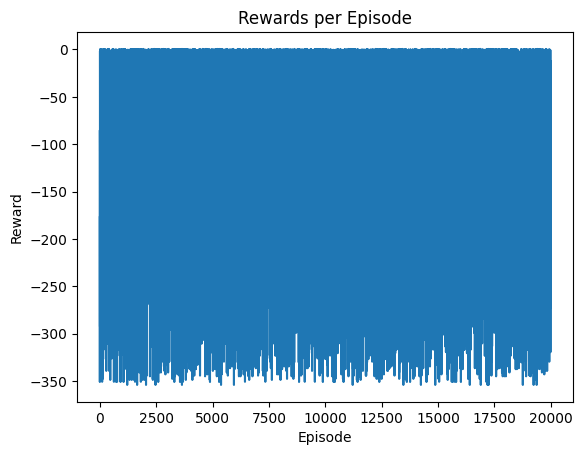

In [805]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("bids_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [806]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="bids_state_to_index.npy")
loaded_qtable = load_q_table(file_path="bids_q_table.npy")

In [807]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                ask: float, bid: float, sma_compare: int, is_short: int
            ):
    state = np.array([[ask, bid, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [808]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [809]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[['ask','bid','sma-compare', 'is_short']].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [810]:
#train_data.tail(15)
len(q_table)

937

In [811]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       901
do_nothing     20
go_short       16
Name: count, dtype: int64

In [812]:
m = train_data[(train_data['predicted_action'] == 'go_long') & (train_data['reward'] > 0)]
m['is_short'].value_counts()

is_short
0    198
1    105
Name: count, dtype: int64

In [813]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

198
105


In [814]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/936
Current Predicted Reward: 0.30116983
Current Actual Reward: 0.30116983
Processed state 100/936
Current Predicted Reward: 47.48507653
Current Actual Reward: -37.10566545999997
Processed state 200/936
Current Predicted Reward: 40.086656789999985
Current Actual Reward: -60.797318449999985
Processed state 300/936
Current Predicted Reward: 42.41194101000002
Current Actual Reward: -58.47203422999995
Processed state 400/936
Current Predicted Reward: 39.660155910000036
Current Actual Reward: -97.59018973000002
Processed state 500/936
Current Predicted Reward: 34.79905912000003
Current Actual Reward: -114.66187199000004
Processed state 600/936
Current Predicted Reward: 35.93129302000002
Current Actual Reward: -142.85595034999997
Processed state 700/936
Current Predicted Reward: 35.93129302000002
Current Actual Reward: -188.74141996000003
Processed state 800/936
Current Predicted Reward: 36.95569300000004
Current Actual Reward: -202.88065601000008
Processed state 900/936
Cu

In [815]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 55.92%


In [816]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[505   0   1]
 [  0   0   0]
 [396  16  19]]


In [817]:
df0['action'].value_counts()

action
go_long       512
do_nothing    425
Name: count, dtype: int64

In [864]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}')]
    m = m[m['is_short'] == is_short]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    result = {
        'counts': counts.get(is_short),
        'total_reward': total_reward,
        'wins': wins,
        'losses': losses
    }

    return result

In [865]:
print(action_reward('go_short', 1)) # go_short 1

{'counts': 14, 'total_reward': 42.377779890000006, 'wins': 13, 'losses': 1}


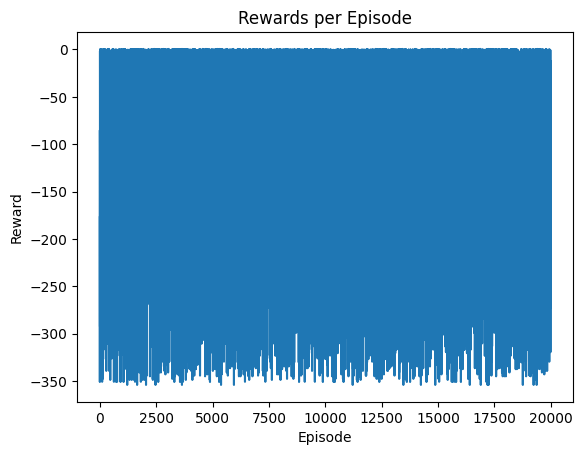

In [820]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [821]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [822]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [823]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [824]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [825]:
'''
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_pred_reward\n        